# activity-by-hour-notes

Copyright © 2024 Erik Hanson

We'll want Ad Viewer activity to vary by time of day and day of week.

This notebook contains some notes about ways that we get get probabilities 
for activity by hour of day. I'd like to save some of the exploration work 
in case it might be helpful later, but I'll probably only implement some 
of this in the simulation files.

In [2]:
import math
import random
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous
from scipy.stats import beta
import numpy as np
import pandas as pd

from typing import Union
from typing import ClassVar


In [3]:
US_POPULATION = 200_000_000

SECONDS_IN_HOUR = 60 * 60
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7

SECONDS_IN_DAY = SECONDS_IN_HOUR * HOURS_IN_DAY
SECONDS_IN_WEEK = SECONDS_IN_DAY * DAYS_IN_WEEK
HOURS_IN_WEEK = DAYS_IN_WEEK * HOURS_IN_DAY


In [4]:
# We'll create beta distributions for the simulation using the mean
# and variance ratio. We need this function to convert to the parameters
# of the beta distribution.

def beta_params_from_mean_and_variance_ratio(
        mean: float, variance_ratio: float
    ) -> tuple[float, float]:
    """
    mean and variance_ratio between 0 and 1.
    variance = variance_ratio * mean * (1 - mean)
    
    Returns the alpha and beta paramters of the specified beta distribution.
    """
    if variance_ratio in (0, 1) or mean in (0, 1):
        return 1, 1  # Should we throw an exception if mean is 0 or 1?
    nu = (1.0 - variance_ratio) / variance_ratio
    a = nu * mean
    b = nu * (1.0 - mean)
    return a, b


### Start with time of day

We'll want activity to vary by time of day.
Each Ad Viewer will have a period of the day when they are active.
Periods will have a start time and a duration.
We'll want to choose the start times and durations to get 
overall activity like we expect with general online ad consumption.
We expect that activity will have a low in the middle of the night around
3am Eastern time and have a peak sometime in the middle of the day.
We'll use a sine curve and say the peak is at 3pm Eastern.
We'll assume that most Ad Viewers are only active for a few
hours but some could be active for much longer. We'll use a beta
distribution to find the durations when the ad viewers are active.

In [16]:
def plot_fn(x, y, y_label="y"):
    """
    Plot a graph of x and y values with a label on the y axis.
    """
    fig, ax = plt.subplots()
    ax.set_xlabel('x') 
    ax.set_ylabel(y_label) 
    ax.plot(x, y) 
    ax.tick_params(axis ='y') 
    plt.show()

In [5]:

# Start distribution is like a scaled sine curve with an offset.
# This is the ratio of the max to min probabilities of the start times.
start_dist_top_to_bottom_ratio = 2.5

# Activity will be in a period beginning with the start time.
# Ads could be delivered with random uniform sampling during this period.
active_duration_mean_hours = 3
active_duration_max_hours = 15

# Hour of day with the smallest expected ad probability
min_activity_hour = 3

start_dist_min_hour = min_activity_hour - active_duration_mean_hours / 2


In [6]:

class DailyActivityStartHourDistribution(rv_continuous):
    """
    Class for the start time distribution.
    By inheriting from rv_continuous, we can have the scipy.stats
    package use the cdf to find random values.
    """
    def __init__(self, top_to_bottom_ratio, min_hour, xtol=1e-6, seed=None):
        super().__init__(a=0, b=24, xtol=xtol, seed=seed)
        self.weight_fn_y_offset = 2 / (top_to_bottom_ratio - 1)
        self.time_offset_hours = 6 + min_hour

    def weight_fn(self, t):
        """
        Unnormailized weights for activity period start times.
        Times are given in hours.
        """
        return self.weight_fn_y_offset + np.sin(
            2 * math.pi * (t - self.time_offset_hours) / HOURS_IN_DAY
        )

    def cum_weight_fn(self, t):
        """
        Integral of start_hour_weight_fn(t) starting from t=0 with constant=0.
        Coded as a formula to match the formula in start_hour_weight_fn(t).
        Used to normailize the wieghts and find the cdf.
        """
        return self.weight_fn_y_offset * t \
            - np.cos(
                2 * math.pi * (t - self.time_offset_hours) / HOURS_IN_DAY
            ) / (2 * math.pi / HOURS_IN_DAY) \
            + np.cos(
                2 * math.pi * (0 - self.time_offset_hours) / HOURS_IN_DAY
            ) / (2 * math.pi / HOURS_IN_DAY)

    def _pdf(self, t):
        """
        Probability of a start time for the window of ad activity.
        Time is given as an hour starting from midnight and can be fractional.
        """
        start_hour_weight_auc = self.cum_weight_fn(24) \
            - self.cum_weight_fn(0)
        return self.weight_fn(t) / start_hour_weight_auc

    def _cdf(self, t):
        """
        Cumulative probability of a start time for the window of ad activity.
        Time is given as an hour starting from midnight and can be fractional.
        """
        start_hour_weight_auc = self.cum_weight_fn(24) \
            - self.cum_weight_fn(0)
        return self.cum_weight_fn(t) / start_hour_weight_auc



In [13]:
# Get distributions for the daily activity start times and durations.

activity_start_dist = DailyActivityStartHourDistribution(
    start_dist_top_to_bottom_ratio, start_dist_min_hour
)

    
# We can use a beta distribution for the duration
beta_mean = active_duration_mean_hours / active_duration_max_hours
beta_var_ratio = beta_mean / 2
a, b = beta_params_from_mean_and_variance_ratio(beta_mean, beta_var_ratio)

activity_duration_dist = beta(a=a, b=b, scale=active_duration_max_hours)


### Do some checks

Check some of the values to verify that they are as expected.


In [22]:
# Look at every half hour in the day

x = np.linspace(0, 24, 48 + 1)

p = activity_start_dist.pdf(x)
c = activity_start_dist.cdf(x)

print("pdf:\n", p)
print("cdf:\n", c)



pdf:
 [0.01279543 0.01148148 0.01068401 0.01041667 0.01068401 0.01148148
 0.01279543 0.01460337 0.01687437 0.01956958 0.02264287 0.02604167
 0.02970781 0.03357857 0.03758772 0.04166667 0.04574561 0.04975476
 0.05362552 0.05729167 0.06069046 0.06376375 0.06645896 0.06872996
 0.0705379  0.07185185 0.07264932 0.07291667 0.07264932 0.07185185
 0.0705379  0.06872996 0.06645896 0.06376375 0.06069046 0.05729167
 0.05362552 0.04975476 0.04574561 0.04166667 0.03758772 0.03357857
 0.02970781 0.02604167 0.02264287 0.01956958 0.01687437 0.01460337
 0.01279543]
cdf:
 [0.         0.00604811 0.01156761 0.01682053 0.02207345 0.02759295
 0.03364106 0.04047076 0.04832165 0.05741588 0.06795428 0.08011303
 0.09404053 0.10985496 0.12764218 0.14745432 0.16930885 0.19318829
 0.21904053 0.2467797  0.27628762 0.30741588 0.33998832 0.37380409
 0.40864106 0.44425962 0.48040678 0.51682053 0.55323428 0.58938144
 0.625      0.65983697 0.69365274 0.72622518 0.75735344 0.78686136
 0.81460053 0.84045277 0.86433221 0.8

In [23]:
# Check that we have the right time for min activity

x[np.argmin(p)], start_dist_min_hour

(1.5, 1.5)

In [24]:
# Check that the half-hour differences in the cdf are close to the 
# scaled pdf values. (Divide by 2 because there are 2 samples / hour.)

c[1:] - c[:-1] - p[:-1] / 2

array([-3.49604434e-04, -2.21240239e-04, -8.90905621e-05,  4.45834789e-05,
        1.77494684e-04,  3.07368906e-04,  4.31983961e-04,  5.49207651e-04,
        6.57034245e-04,  7.53618801e-04,  8.37308731e-04,  9.06672076e-04,
        9.60522011e-04,  9.97937147e-04,  1.01827730e-03,  1.02119445e-03,
        1.00663868e-03,  9.74859040e-04,  9.26399293e-04,  8.62088597e-04,
        7.83027326e-04,  6.90568241e-04,  5.86293341e-04,  4.71986800e-04,
        3.49604434e-04,  2.21240239e-04,  8.90905621e-05, -4.45834789e-05,
       -1.77494684e-04, -3.07368906e-04, -4.31983961e-04, -5.49207651e-04,
       -6.57034245e-04, -7.53618801e-04, -8.37308731e-04, -9.06672076e-04,
       -9.60522011e-04, -9.97937147e-04, -1.01827730e-03, -1.02119445e-03,
       -1.00663868e-03, -9.74859040e-04, -9.26399293e-04, -8.62088597e-04,
       -7.83027326e-04, -6.90568241e-04, -5.86293341e-04, -4.71986800e-04])

### Compare 2 methods to get samples from the distribution

1. Use the distribution class `rvs()` method.

2. Use `random.choices()`.

In [28]:
print(datetime.now())

2024-01-25 08:27:53.814578


In [30]:
# Get some sample counts to check the distribution

sample_count = 100_000

print(f"{datetime.now()}  Starting first sample")

samples_1 = activity_start_dist.rvs(size=sample_count)

print(f"{datetime.now()}  Starting second sample")

samples_2 = activity_start_dist.rvs(size=sample_count)

print(f"{datetime.now()}  Done")


2024-01-25 08:29:39.758154  Starting first sample
2024-01-25 08:30:57.925533  Starting second sample
2024-01-25 08:32:17.416154  Done


So the time for 100K samples is around 80 seconds.


In [34]:
# We really only need 1-second accuracy,
# Try just choosing integer values

time_in_seconds = np.linspace(0, SECONDS_IN_DAY, SECONDS_IN_DAY,
                              endpoint=False).astype(np.int32)

time_in_seconds[-5:] / SECONDS_IN_HOUR


array([23.99861111, 23.99888889, 23.99916667, 23.99944444, 23.99972222])

In [46]:
time_in_seconds[-5:]

array([86395, 86396, 86397, 86398, 86399])

In [35]:

cum_weights = activity_start_dist.cdf(
    (time_in_seconds + 1) / SECONDS_IN_HOUR
)


print(f"{datetime.now()}  Starting first sample")

samples_1b = random.choices(time_in_seconds, cum_weights=cum_weights,
                             k=sample_count)

print(f"{datetime.now()}  Starting second sample")

samples_2b = random.choices(time_in_seconds, cum_weights=cum_weights,
                             k=sample_count)

print(f"{datetime.now()}  Done")


2024-01-25 12:58:46.860202  Starting first sample
2024-01-25 12:58:46.968633  Starting second sample
2024-01-25 12:58:47.062050  Done


In [36]:
samples_2b[:10]

[29148, 47805, 13692, 66067, 77550, 48683, 48391, 31144, 36556, 33714]

It seems that the `random.choices()` is much better if we just need to
choose seconds in a day. We could try adjusting the xtol setting in the 
distribution to imrpove performance, but random.choices seems ideal for 
the case of choosing seconds when we have the cdf.

## Day of Week Variations

We may want to periods of activity to be different on different days
of the week. We'll also want some days to have more activity than others.
If we do each day independently, we'll get some large changes in the 
probablilities from one day to the next. So we'll want to "blend" the 
distributions from different days to get smoother changes from 
day-to-day.

We'll allow different distributions on each day of the week and different 
weights for the total activity on each day of the week. We'll use a 
linear combination of the distributions from both days to "blend" 
the distributions in the hours before and after the date boundries.

We'll have weeks start with Monday to match the ISO-8601 standard, but 
we'll assume hour of day is in a local time for the simulations.

In [7]:
# Define the distributions that we want on each day of the week along witt 
# the relative weight fo each day of the week.  Weeks start on Monday.

weekly_activity_parameters = {
    "max_to_min_ratio" : [2.5] * 5 + [3] * 2,
    "min_activity_hour" : [3] * 5 + [4] * 2,
    "active_duration_mean_hours" : [3] * 7,
    "active_duration_var_ratio" : [0.1] * 5 + [0.15] * 2,
    "active_duration_max_hours" : [15] * 5 + [12] * 2,
    "daily_activity_weight" : [1, 1.2, 1.3, 1.1, 0.9, 0.7, 0.5],
}

# Calculate the min hour for the distribution of activity start times.
weekly_activity_parameters["min_start_hour"] = [
    6 + min_activity_hour - duration_mean_hours / 2
    for min_activity_hour, duration_mean_hours in zip(
        weekly_activity_parameters["min_activity_hour"],
        weekly_activity_parameters["active_duration_mean_hours"]
    )
]

# The total hours (before and after day changes) when we blend distributions.
daily_activity_blend_hours = 6


In [8]:
weekly_activity_parameters

{'max_to_min_ratio': [2.5, 2.5, 2.5, 2.5, 2.5, 3, 3],
 'min_activity_hour': [3, 3, 3, 3, 3, 4, 4],
 'active_duration_mean_hours': [3, 3, 3, 3, 3, 3, 3],
 'active_duration_var_ratio': [0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15],
 'active_duration_max_hours': [15, 15, 15, 15, 15, 12, 12],
 'daily_activity_weight': [1, 1.2, 1.3, 1.1, 0.9, 0.7, 0.5],
 'min_start_hour': [7.5, 7.5, 7.5, 7.5, 7.5, 8.5, 8.5]}

We'll probably put this into a class.
Blending activity start times is each because we just need an array
with probablilities for each second of the week.
Blending the durations is trickier...

Start with the start times.  Do this:

1. Find the probabilities by second for each day.

1. weight by the daily weights.

1. Blend by day boundries.

1. Normailze to get second-of-week cdf.


In [9]:
seconds_in_day_with_end = np.linspace(
    0, SECONDS_IN_DAY, SECONDS_IN_DAY + 1, endpoint=True
).astype(np.int32)

seconds_in_day_with_end[-3:]

array([86398, 86399, 86400])

In [10]:
# Find the probabilities by second for each day of the week

daily_start_second_probs = []

for i_day in range(7):
    activity_start_dist = DailyActivityStartHourDistribution(
        weekly_activity_parameters["max_to_min_ratio"][i_day],
        weekly_activity_parameters["min_start_hour"][i_day]
    )
    
    second_in_day_probs = activity_start_dist.cdf(
        (seconds_in_day_with_end[1:]) / SECONDS_IN_HOUR
    ) - activity_start_dist.cdf(
        (seconds_in_day_with_end[:-1]) / SECONDS_IN_HOUR
    )

    daily_start_second_probs.append(second_in_day_probs)

In [11]:
daily_start_second_probs[0][:10]

array([1.48956873e-05, 1.48951040e-05, 1.48945208e-05, 1.48939375e-05,
       1.48933542e-05, 1.48927709e-05, 1.48921876e-05, 1.48916043e-05,
       1.48910209e-05, 1.48904375e-05])

In [12]:
second_in_day_probs[:10]

array([1.86195901e-05, 1.86189223e-05, 1.86182544e-05, 1.86175866e-05,
       1.86169187e-05, 1.86162507e-05, 1.86155827e-05, 1.86149147e-05,
       1.86142467e-05, 1.86135786e-05])

In [13]:
# There's a jump at midnight when we change the daily start distributions

daily_start_second_probs[4][-5:], daily_start_second_probs[5][:5]

(array([1.48986032e-05, 1.48980200e-05, 1.48974369e-05, 1.48968537e-05,
        1.48962705e-05]),
 array([1.86195901e-05, 1.86189223e-05, 1.86182544e-05, 1.86175866e-05,
        1.86169187e-05]))

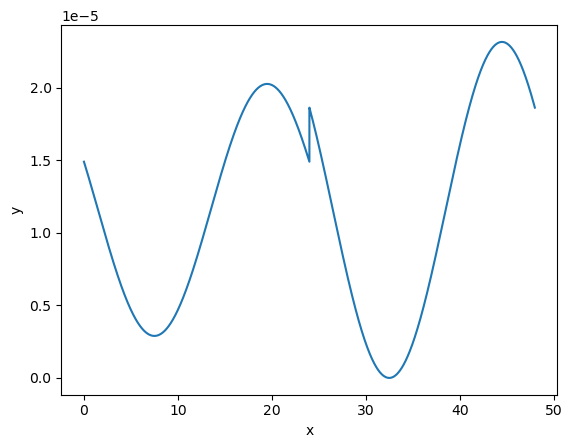

In [19]:
# We can do a plot to show this

seconds_in_day_no_end = seconds_in_day_with_end[:-1]

x = np.append(
    seconds_in_day_no_end,
    (seconds_in_day_no_end + SECONDS_IN_DAY)
) / SECONDS_IN_HOUR

y = np.append(daily_start_second_probs[4], daily_start_second_probs[5])


plot_fn(x,y)


### Blending notes

Let's say we want to blend the last 3 hours of a day with the last 3 hours
of the next day. Let $b_i$ be the probabilities for the last 3 hours in the 
first day and $c_i$ be the probabilities for the last 3 hours in the second
day. Let $\alpha_i$ be weight going from 0 to 0.5 used to blend the
probabilities.  A simple blending equation is:

$b'_i = \alpha_i c_i + (1 - \alpha_i) b_i$

Consider these weighted sums:

$w_b = \sum_i \alpha_i b_i$

and 

$w_c = \sum_i \alpha_i c_i$

if these weights are equal, then the sums of the blended probabilities 
will not change and we won't need to renormalize to find daily probabilities.
But if they aren't equal, we can add an adjustment factor ($r$) to make sure 
that the sum of the blended probabilities is unchanged.

$b'_i = r \alpha_i c_i + (1 - r) (1 - \alpha_i) b_i$

We'll want

$r w_c = (1 - r) w_b$

which gives

$r = w_b \, / \, (w_b + w_c)$

This is what we want when the expected activity on each day is the same.
When the expected activity on the two days is different, then we want 
the probabilites multiplied by the expected daily activities to match.
This is more complicated...

In that case, I think we can do the blending with this equation:

$b'_i = (r \alpha_i c_i + (1 - r) (1 - \alpha_i) b_i) (1 - \alpha_i t)$

If $n_b$ and $n_c$ are the expected activitiy levels on the 2 days,
then we want the expected activity level at the end of the first day 
to be $m = (n_b + n_c) \, / \, 2 n_b$.

We can solve for $t$ as follows:

Given these weights

$k_b = \sum_i \alpha_i (1 - \alpha) b_i$

$k_c = \sum_i \alpha_i^2 c_i$

We can expect that our blended $b_i'$ (and the other daily probabilities) 
will be multiplied by

$1 \, / \, (1 - (k_b + k_c) t / 2)$

to normalize the $b_i'$ and get daily probabilities.

So we'll want the new scaling to match the expected activity level.
($\alpha$ is $1/2$ at the end of the day, so we scale by $1 - t/2$
and the normalization constant above.)

$(1 - t / 2) \, / \, (1 - (k_b + k_c) t / 2) = m$

$(1 - t / 2) \, / \, m = 1 - (k_b + k_c) t / 2$

$2 / m - t / m = 2 - (k_b + k_c) t$

$2 / m - 2 = (1 / m - k_b - k_c) t$

$t = (2 / m - 2) \, / \, (1 / m - k_b - k_c)$

$t = (2 (1 - m)) \, / \, (1 - m (k_b + k_c))$

When $m = 1$ this gives $t = 0$ as expected.

In [ ]:
# Start without adjusting for differences in daily activity levels.
#
# Blend the probabilities in the hours around midnight and keep the
# sum of the blended results equal to the some of the probabilities 
# that we started with.
#
# Just blending the values could have a problem because the total 
# of the blended probabilities might not sum to 1.0, so we compute 
# weights to use in the blending to keep the resulting sum = 1.0.

blend_seconds_each_day = 3 * SECONDS_IN_HOUR

blend_weights_unnormalized = np.linspace(
    0, 0.5, blend_seconds_each_day, endpoint=False
)


